# Exploring Model For Pollen Count

In this notebook, we will perform data preprocessing for the pollen count data. We will also apply feature selection methods on the dataset. We will try several regression models to compare and discuss the most reasonable and appropriate model.

In [2]:
import pickle
import datetime
import pandas as pd
import numpy as np

# visulization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, plot_importance

# metrics 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score


import math
from prophet import Prophet
# from bayes_opt import BayesianOptimization


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('gfs_preprocessed_new.csv')

In [4]:
df

,grass_count,t_mean_9am,t_min_9am,t_max_9am,t_sd_9am,t_2m_mean_9am,t_2m_min_9am,t_2m_max_9am,t_2m_sd_9am,msl_mean_9am,...,pwat_mean_4pm,pwat_min_4pm,pwat_max_4pm,pwat_sd_4pm,date,year,train,month,day,seasonal_avg_count
0,0.0,285.87500,280.1000,290.80000,4.780080,285.7500,280.40000,290.30000,4.430575,101775.75,...,13.875000,13.000000,14.900000,0.880814,2000-01-01,2000,2000-01,1,01-01,0.000000
1,0.0,285.87500,280.1000,290.80000,4.780080,285.7500,280.40000,290.30000,4.430575,101775.75,...,16.925000,13.600000,20.000000,2.780138,2000-01-02,2000,2000-01,1,01-02,0.000000
2,0.0,285.87500,280.1000,290.80000,4.780080,285.7500,280.40000,290.30000,4.430575,101775.75,...,22.625000,18.800000,24.700000,2.617091,2000-01-03,2000,2000-01,1,01-03,0.000000
3,0.0,285.87500,280.1000,290.80000,4.780080,285.7500,280.40000,290.30000,4.430575,101775.75,...,16.400000,12.300000,20.200000,3.799123,2000-01-04,2000,2000-01,1,01-04,0.000000
4,0.0,285.87500,280.1000,290.80000,4.780080,285.7500,280.40000,290.30000,4.430575,101775.75,...,14.550000,13.400000,15.100000,0.776745,2000-01-05,2000,2000-01,1,01-05,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7671,119.0,290.56924,290.1858,290.96576,0.372835,290.5599,286.59177,294.92386,3.661287,101139.20,...,19.927906,11.900000,29.617905,9.217530,2020-12-27,2020,2020-12,12,12-27,24.047619
7672,52.0,290.56924,290.1858,290.96576,0.372835,290.5599,286.59177,294.92386,3.661287,101139.20,...,15.316968,14.800000,15.933380,0.585012,2020-12-28,2020,2020-12,12,12-28,31.142857
7673,2.0,290.56924,290.1858,290.96576,0.372835,290.5599,286.59177,294.92386,3.661287,101139.20,...,20.322964,17.733380,24.500000,3.043544,2020-12-29,2020,2020-12,12,12-29,39.761905
7674,9.0,290.56924,290.1858,290.96576,0.372835,290.5599,286.59177,294.92386,3.661287,101139.20,...,23.850000,21.100000,26.000000,2.350177,2020-12-30,2020,2020-12,12,12-30,14.285714


### Discover the correlation

In [5]:
corr_df = df.copy()

In [6]:
corr_df = corr_df.drop(['date',  'train', 'year', 'day'], axis=1)

In [7]:
corr_cols = corr_df.columns.to_list()
corr = corr_df[corr_cols].corr()

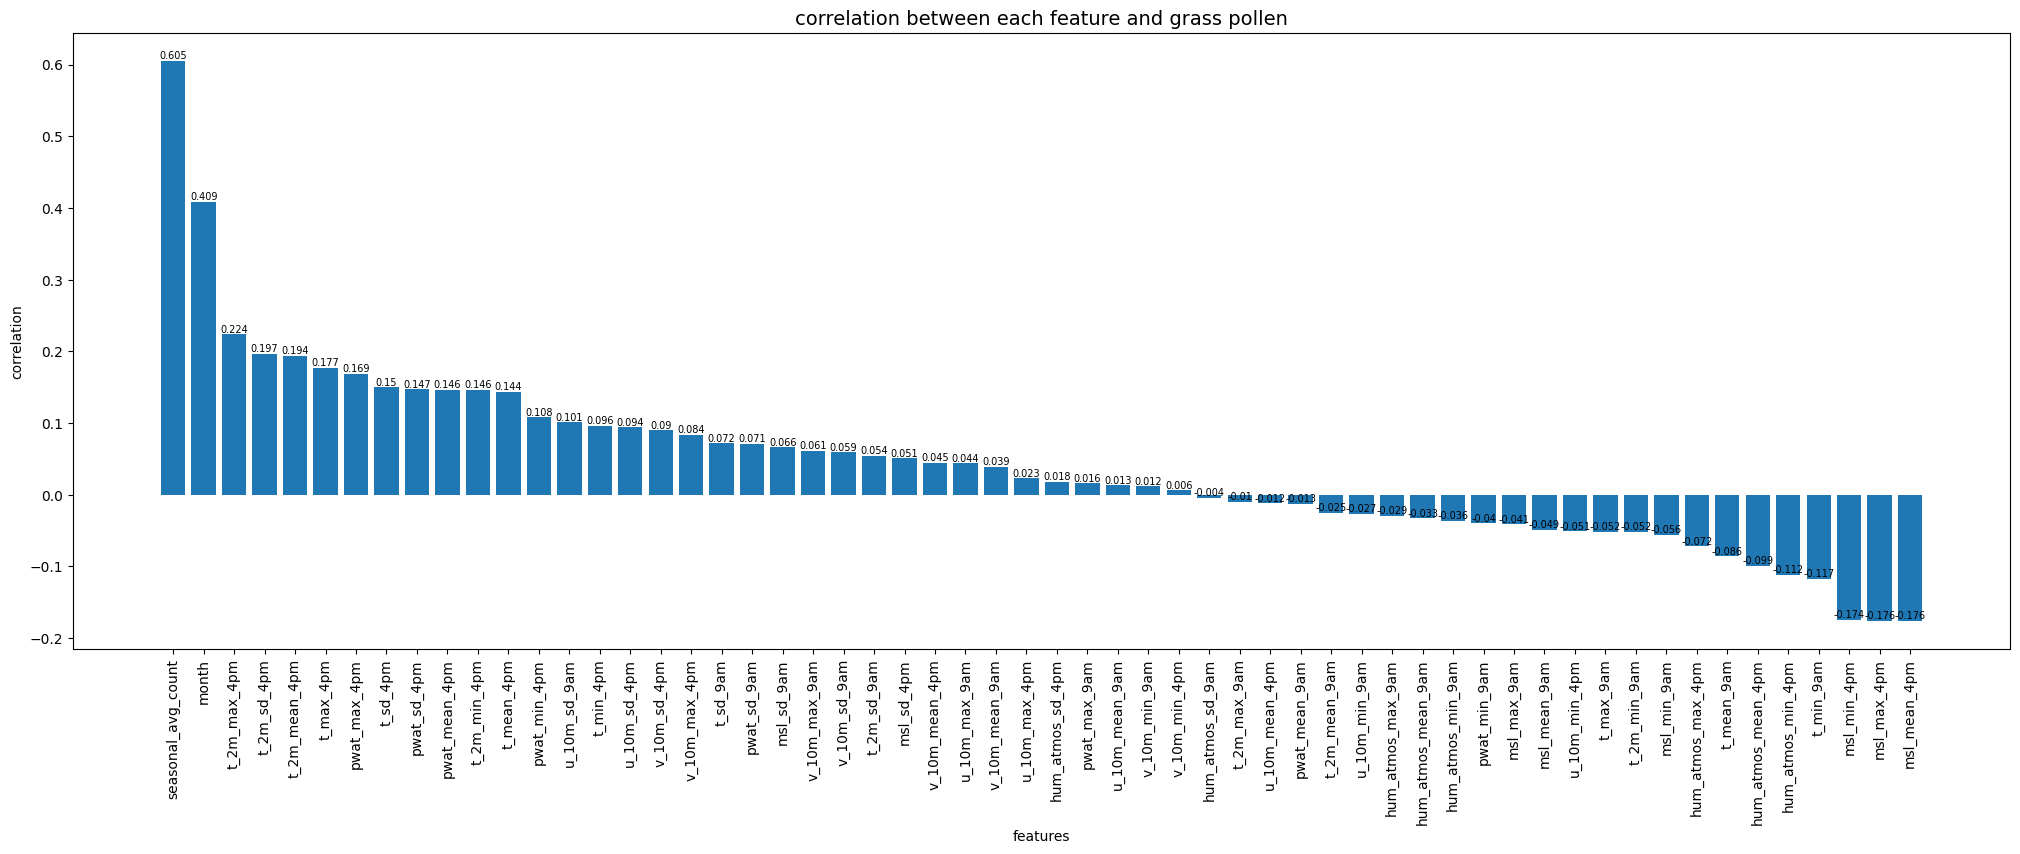

In [26]:
# sort the dictionary of correlation
sorted_corr = sorted(corr['grass_count'].items(), key=lambda item: item[1], reverse = True)

# correlation plot for top 50 feature
# select_corr = sorted_corr[1:21]
plt.figure(figsize=(25,8))
x = list(x[0] for x in sorted_corr[1:])
y = list(round(x[1],3) for x in sorted_corr[1:])
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("correlation between each feature and grass pollen", fontsize=14)
plt.ylabel("correlation")
plt.xlabel("features")
for a, b in zip(x, y):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
plt.show()

## Modelling

### Lightgbm

In [9]:
# training dataset
train_data = df.loc[(df['train'] != '2020-12') & (df['train'] != '2020-11')& (df['train'] != '2020-10')]

# plot
train_data_plot = train_data.copy()
train_data_plot['date'] = train_data_plot['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
train_data_plot.index = train_data_plot['date']


X_train = train_data.drop(['grass_count', 'year', 'date', 'train', 'day'], axis = 1).reset_index(drop = True)
y_train = train_data['grass_count']
print(X_train.shape)
print(y_train.shape)

(7584, 58)
(7584,)


In [10]:
X_train

,t_mean_9am,t_min_9am,t_max_9am,t_sd_9am,t_2m_mean_9am,t_2m_min_9am,t_2m_max_9am,t_2m_sd_9am,msl_mean_9am,msl_min_9am,...,v_10m_mean_4pm,v_10m_min_4pm,v_10m_max_4pm,v_10m_sd_4pm,pwat_mean_4pm,pwat_min_4pm,pwat_max_4pm,pwat_sd_4pm,month,seasonal_avg_count
0,285.87500,280.1000,290.8000,4.780080,285.75000,280.40000,290.30000,4.430575,101775.75,101654.000,...,3.300000,1.499999,6.000000,1.961293,13.875,13.0,14.9,0.880814,1,0.0
1,285.87500,280.1000,290.8000,4.780080,285.75000,280.40000,290.30000,4.430575,101775.75,101654.000,...,-2.450000,-8.000000,2.900000,5.402777,16.925,13.6,20.0,2.780138,1,0.0
2,285.87500,280.1000,290.8000,4.780080,285.75000,280.40000,290.30000,4.430575,101775.75,101654.000,...,3.100000,1.099999,5.700000,1.971464,22.625,18.8,24.7,2.617091,1,0.0
3,285.87500,280.1000,290.8000,4.780080,285.75000,280.40000,290.30000,4.430575,101775.75,101654.000,...,4.850000,3.500000,6.200000,1.161895,16.400,12.3,20.2,3.799123,1,0.0
4,285.87500,280.1000,290.8000,4.780080,285.75000,280.40000,290.30000,4.430575,101775.75,101654.000,...,3.975000,2.800000,5.600000,1.286792,14.550,13.4,15.1,0.776745,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,285.27008,285.0634,285.3754,0.140418,286.55835,284.42596,288.02914,1.629595,100903.83,100535.305,...,3.576732,1.849349,6.291419,1.977929,11.825,7.8,14.5,3.065262,9,0.0
7580,285.27008,285.0634,285.3754,0.140418,286.55835,284.42596,288.02914,1.629595,100903.83,100535.305,...,1.996604,0.418494,3.904170,1.756942,8.675,7.4,9.4,0.921502,9,0.0
7581,285.27008,285.0634,285.3754,0.140418,286.55835,284.42596,288.02914,1.629595,100903.83,100535.305,...,0.020897,-2.890449,3.388625,2.971636,8.150,7.6,8.9,0.544671,9,0.0
7582,285.27008,285.0634,285.3754,0.140418,286.55835,284.42596,288.02914,1.629595,100903.83,100535.305,...,-6.098774,-9.160632,-4.398267,2.248680,19.575,12.3,23.2,5.115581,9,0.0


In [11]:
# testing dataset
dev_data = df.loc[(df['train'] == '2020-12') | (df['train'] == '2020-11') | (df['train'] == '2020-10')]

# plot
dev_data_plot = dev_data.copy()
dev_data_plot['date'] = dev_data_plot['date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
dev_data_plot.index = dev_data_plot['date']

X_dev = dev_data.drop(['grass_count', 'year', 'date', 'train', 'day'], axis = 1).reset_index(drop = True)
y_dev = dev_data['grass_count']
print(X_dev.shape)
print(y_dev.shape)

(92, 58)
(92,)


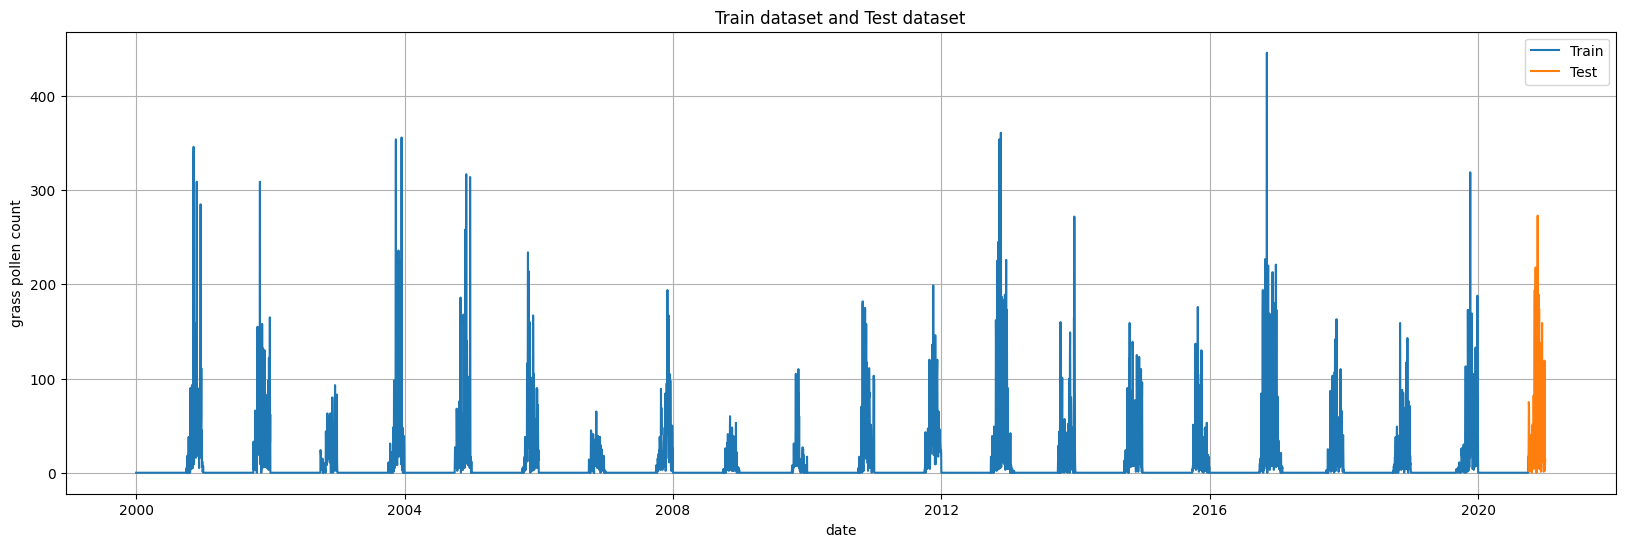

In [12]:
plt.figure(figsize=(20,6))
plt.grid()
plt.plot(train_data_plot['grass_count'], label='Train')
plt.plot(dev_data_plot['grass_count'], label='Test')
plt.legend(loc='best')
plt.title('Train dataset and Test dataset')
plt.xlabel('date')
plt.ylabel('grass pollen count')
plt.show()

In [13]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

# Evaluation
print('The R2 score of prediction is: {}'.format(lgbm.score(X_dev, y_dev))) 

The R2 score of prediction is: 0.23424839491411098


In [14]:
# predict
y_pred = lgbm.predict(X_dev)
# check neagative and change to 0
y_pred = np.where(y_pred<0, 0, y_pred)
# round to integer
y_pred = np.rint(y_pred)

# evaluation
print('='*25 + 'Evaluation results' + '='*25)
print('The MSE of prediction is: {}'.format(mean_squared_error(y_dev, y_pred)))
print('The RMSE of prediction is: {}'.format(math.sqrt(mean_squared_error(y_dev, y_pred))))
print('The R2 score of prediction is: {}'.format(r2_score(y_dev, y_pred))) 

=========================Evaluation results=========================
The MSE of prediction is: 2853.6521739130435
The RMSE of prediction is: 53.41958605149467
The R2 score of prediction is: 0.23393780726101376


In [15]:
result = pd.DataFrame(y_pred)
result['test'] = list(y_dev)
result.index = list(dev_data['date'])
result = result.rename(columns = {0: 'baseline'})
result.to_csv("result_baseline_gfs.csv")

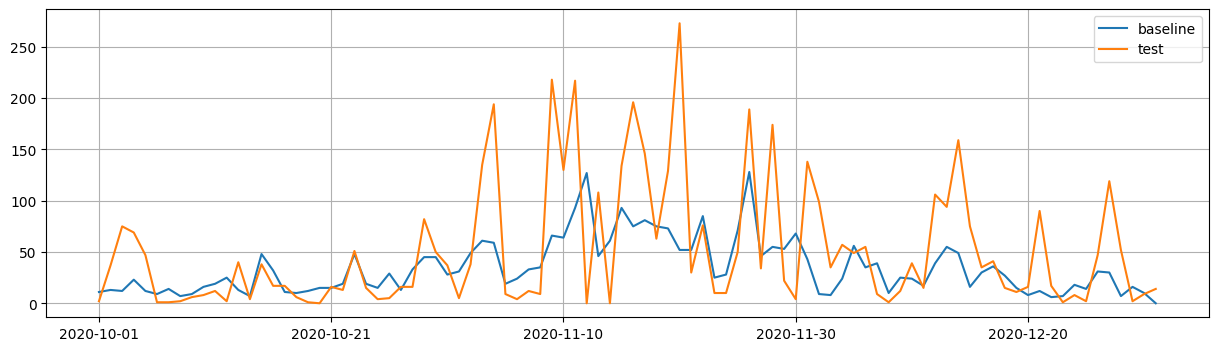

In [16]:
result.plot(figsize=(15,4))
plt.grid()
plt.legend(['baseline', 'test'])
plt.show()

<AxesSubplot:title={'center':'Top 20 Feature importance '}, xlabel='Feature importance', ylabel='Features'>

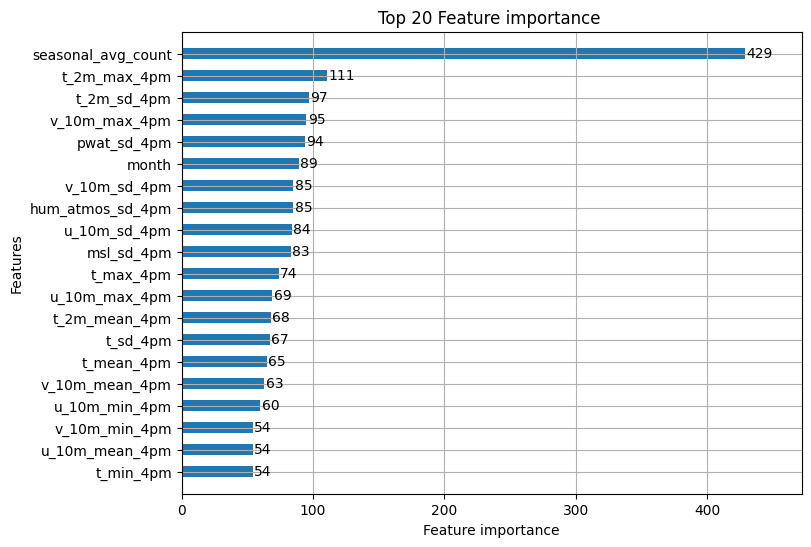

In [17]:
plot_importance(lgbm, height=.5, max_num_features=20, figsize=(8, 6), title="Top 20 Feature importance ")

In [18]:
df.columns

Index(['grass_count', 't_mean_9am', 't_min_9am', 't_max_9am', 't_sd_9am',
       't_2m_mean_9am', 't_2m_min_9am', 't_2m_max_9am', 't_2m_sd_9am',
       'msl_mean_9am', 'msl_min_9am', 'msl_max_9am', 'msl_sd_9am',
       'hum_atmos_mean_9am', 'hum_atmos_min_9am', 'hum_atmos_max_9am',
       'hum_atmos_sd_9am', 'u_10m_mean_9am', 'u_10m_min_9am', 'u_10m_max_9am',
       'u_10m_sd_9am', 'v_10m_mean_9am', 'v_10m_min_9am', 'v_10m_max_9am',
       'v_10m_sd_9am', 'pwat_mean_9am', 'pwat_min_9am', 'pwat_max_9am',
       'pwat_sd_9am', 't_mean_4pm', 't_min_4pm', 't_max_4pm', 't_sd_4pm',
       't_2m_mean_4pm', 't_2m_min_4pm', 't_2m_max_4pm', 't_2m_sd_4pm',
       'msl_mean_4pm', 'msl_min_4pm', 'msl_max_4pm', 'msl_sd_4pm',
       'hum_atmos_mean_4pm', 'hum_atmos_min_4pm', 'hum_atmos_max_4pm',
       'hum_atmos_sd_4pm', 'u_10m_mean_4pm', 'u_10m_min_4pm', 'u_10m_max_4pm',
       'u_10m_sd_4pm', 'v_10m_mean_4pm', 'v_10m_min_4pm', 'v_10m_max_4pm',
       'v_10m_sd_4pm', 'pwat_mean_4pm', 'pwat_min_4pm'

In [19]:
feature_type = ['t', 't_2m', 'msl', 'hum_atmos', 'v_10m', 'u_10m', 'pwat', 'month', 'seasonal_avg_count']

In [20]:
feature_imp_df = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X_train.columns)), columns=['Value','Feature'])

In [21]:
def extract_df(feature, df, colnames):
    '''
    extract each type of features and grass count to a single dataframe
    '''
    all_list = list(filter(lambda x: feature in x, colnames))
    final_df = pd.DataFrame()
    for lst in all_list:
        one_df = df[df['Feature'] == lst]
        final_df = pd.concat([final_df, one_df], axis=0)

    return final_df

In [22]:
colnames = feature_imp_df['Feature'].to_list()
avg_imp_dict = {}
for feature in feature_type:
    single_df = extract_df(feature, feature_imp_df, colnames)
    avg_imp_dict[feature] = round(single_df['Value'].mean(), 4)

In [23]:
feature_avg_imp = pd.DataFrame.from_dict(avg_imp_dict, orient="index")
feature_avg_imp = feature_avg_imp.rename(columns = {0: 'Avg value'})
feature_avg_imp = feature_avg_imp.sort_values(by='Avg value', ascending = False)

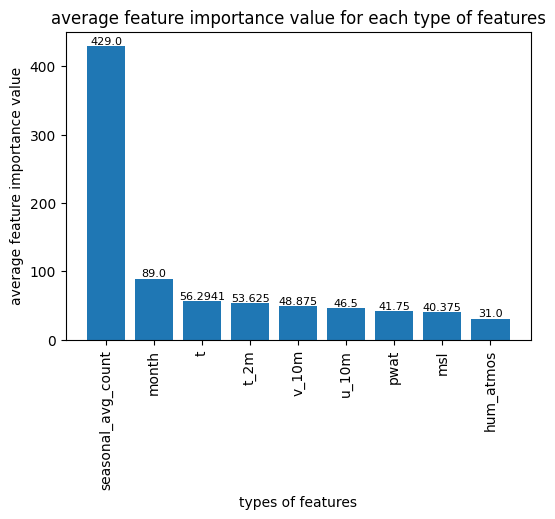

In [24]:
plt.figure(figsize=(6,4))
plt.bar(feature_avg_imp.index.to_list(), feature_avg_imp['Avg value'])
plt.xticks(rotation=90)
plt.title("average feature importance value for each type of features")
plt.ylabel("average feature importance value")
plt.xlabel("types of features")
for a, b in zip(feature_avg_imp.index.to_list(), feature_avg_imp['Avg value']):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.show()